# Multivariate regression for EV energy consumption prediction

Data description:

In 'trips_bulk.csv', EV data from electric buses operating in the City of Turku are recorded; in total, the dataset contains 25 256 unique trips that were made in year 2017 on one of the four route segments:

 - Turku harbor --> Marketplace
 - Marketplace --> Turku Airport
 - Turku Airport --> Marketplace
 - Marketplace --> Turku harbor
 
The individual trips are encoded in the data by parameter 'duration', wherein a zero value designates the beginning point of a trip.

The variables in the dataset are:

 - timestamp: A timestamp string in format yyyy-MM-DD HH:mm:ss
 - gpslong: GPS Longitude
 - gpslat: GPS Latitude
 - altitude: Approximate altitude from sea level in meters, that has been inferred from (gpslong, gpslat) by interpolation
 - speed: the instantaneous vehicle drivin speed in km/h
 - soc: the state of charge of the EV battery in %
 - temp: ambient temperature in deg C
 - duration: a running duration of the current trip in s
 
Predicted variable is the (normalized) SOC, that is, given a sequence of the other variables, the task of our model is to infer the corresponding SOC sequence.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/trips_bulk.csv')

In [3]:
data = data[:100000]

In [4]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.677215,5
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20


### Explore the data

In [5]:
len(data)

100000

In [6]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.677215,5
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gpslong,100000.0,22.280646,0.010808,22.263518,22.269668,22.282350,22.287822,22.301045
gpslat,100000.0,60.480276,0.019935,60.450903,60.461375,60.478852,60.499802,60.511088
altitude,100000.0,27.785846,13.392020,7.455623,16.000889,24.868428,36.554545,57.200000
speed,100000.0,30.574375,16.407098,0.000000,18.941406,34.113281,43.839844,255.996094
soc,100000.0,70.945639,8.563717,24.042857,69.793750,73.181818,76.000000,84.100000
temp,100000.0,1.219536,4.032229,-39.849462,-0.588785,2.012308,3.695444,10.639733
duration,100000.0,544.320280,334.857363,0.000000,256.000000,527.000000,814.000000,1604.000000


Seems like we have some outliers at least in  temp and speed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021716CC7710>,
      dtype=object)

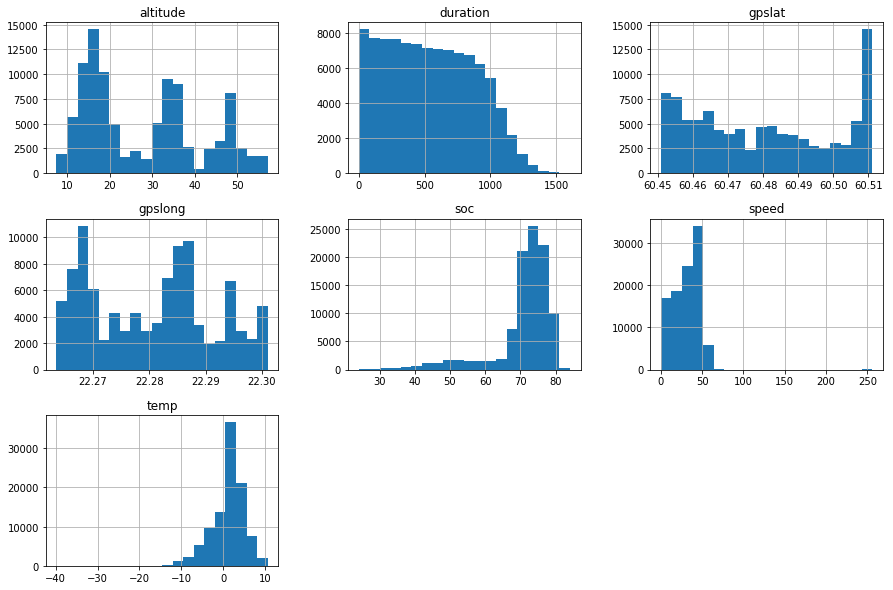

In [8]:
data.hist(bins=20, figsize=(15,10))

A very nice way to outline the data is to plot a heatmap representation of (gpslat, gpslong) data utilizing matplotlibs 2d-histogram capability. With a binning dense enough, we clearly outline the representation of the turku ebus route 1

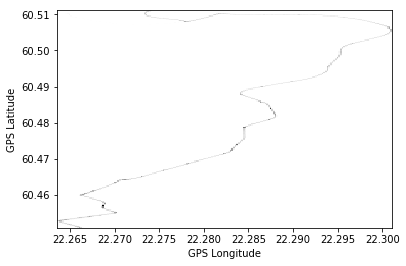

In [9]:
plt.figure()
h, xedges, yedges, _ = plt.hist2d(data['gpslong'], data['gpslat'], bins=200, cmap='binary')
plt.xlabel('GPS Longitude')
plt.ylabel('GPS Latitude')
plt.show()

Next, we need some way of accessing the individual samples. We will build indexing based on the duration variable

In [10]:
def build_sample_indices(data, col):
    """
    Builds sequence indices based on duration data
    Iterate over the rows in data and increment index whenever duration == 0
    
    Args:
        data (pd.DataFrame) : The dataframe whose indices are to be built.
        col (string) : The column of the dataframe with respect to the indexing
    Returns:
         data (pd.Series) : Data with an added column for the sequence indices
    """
    
    idx = 0
    seq_indices = []
    for _, row in data.iterrows():
        if row[col] == 0:
            #increment index and begin new sequence
            idx += 1
            seq_indices.append(idx)
        else:
            seq_indices.append(idx)
    
    data['sequence'] = seq_indices
    
    return data

Iterate over the rows in the full dataset and build the sequence indices

In [11]:
data = build_sample_indices(data, 'duration')

In [12]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,sequence
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0,1
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.677215,5,1
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10,1
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15,1
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20,1


In [13]:
data['sequence'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Finally we get to do some actual feature engineering. First let's remove the outliers in temp and speed. 

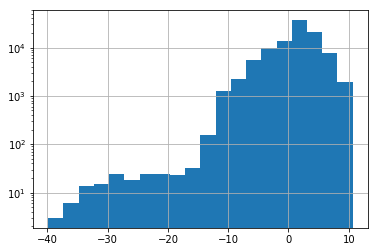

In [14]:
data['temp'].hist(bins=20)
plt.yscale('log', nonposy='clip')

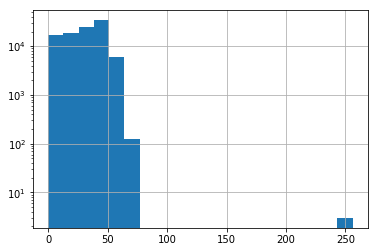

In [15]:
data['speed'].hist(bins=20)
plt.yscale('log', nonposy='clip')

In [16]:
data[data['speed'] > 100]

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,sequence
2495,2017-01-02 11:40:41,22.290632,60.509620,42.931516,255.996094,78.594231,-33.294118,159,13
59900,2017-02-14 20:02:25,22.284535,60.478697,24.844774,255.996094,76.278846,-39.473118,597,292
59902,2017-02-14 20:02:37,22.284535,60.478697,24.844774,255.996094,76.255769,-16.666667,609,292


In [17]:
def remove_outliers(data):
    
    # for each sequence in data, replace the temp with median
    # drop unusually high values in speed
    seq_ids = list(data['sequence'].unique())
    data = data.drop(index=data[data['speed'] > 100].index)
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        data.loc[seq.index, 'temp'] = np.median(seq['temp'])
                
    return data

In [18]:
data = remove_outliers(data)

In [19]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,sequence
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.428363,0,1
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.428363,5,1
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.428363,10,1
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.428363,15,1
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.428363,20,1


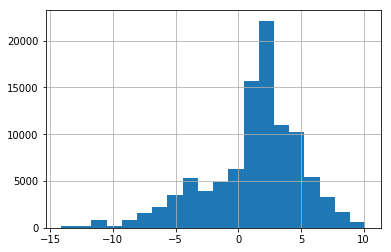

In [20]:
data['temp'].hist(bins=20)

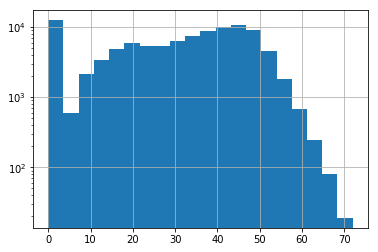

In [21]:
data['speed'].hist(bins=20)
plt.yscale('log', nonposy='clip')

We want to represent the data not tied to an absolute geolocation, but instead we want relative columns for gpslat, long and altitude. For gpslat / long, we want to replace with a running distance feature from the sequence origin. For this, we will utilize something called Haversine formula for computing the distance between two (gpslat, gpslong) pairs.

In [22]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [23]:
haversine(22.273871666666697, 60.510728333333304 , 22.273871666666697 , 60.510728333333304)

0.0

In [24]:
def compute_distance_between_rows(row1, row2, gpslat_col, gpslong_col):
    """
    Compute the haversine distance given two rows sliced from a pd.DataFrame.
    Rows are expected to be identical in their columns
    
    Args:
        row1 (pd.Series of shape (1, n_features)) 
        row2 (pd.Series of shape (1, n_features))
        gpslat_col (string) : the identifier of the column of gps latitude in both rows
        gpslong_col (string) : the identifier of the column of gps longitude in both rows
    
    Returns:
        distance (float)
    """
    lon1 = row1[gpslong_col]
    lat1 = row1[gpslat_col]
    lon2 = row2[gpslong_col]
    lat2 = row2[gpslat_col]
        
    return haversine(lon1, lat1, lon2, lat2)
    

In [25]:
seq = data[data['sequence'] == 3]

In [26]:
compute_distance_between_rows(seq.iloc[0,:], seq.iloc[0,:], 'gpslat', 'gpslong')

0.0

In [27]:
def convert_sequence_to_relative(seq):
    """
    Converts gpslat, gpslong and altitude to running relative metrics
    
    Args:
        seq (pd.DataFrame) : the sequence to be converted
    
    Returns:
        distance (pd.Series) : running distance offset (meters) from the beginning of the series
        rel_altitude (pd.Series) : running altitude offset (meters) from the beginning of the series
        rel_soc (pd.Series) : the additive inverse of SOC offset from beginning of the series
    """
    first_row = seq.iloc[0,:]
    args = (first_row, 'gpslat', 'gpslong')
    
    distance = seq.apply(compute_distance_between_rows, args=args, axis=1)
    rel_altitude = seq.apply(lambda row : row['altitude'] - first_row['altitude'], axis=1)
    rel_soc = seq.apply(lambda row : -1*(row['soc'] - first_row['soc']), axis=1)
    
    return distance, rel_altitude, rel_soc
    

Testing

In [ ]:
seq = data[data['sequence'] == 4]

In [ ]:
seq

In [ ]:
convert_sequence_to_relative(seq)

In [ ]:
seq

So now we have driven distance and altitude in a relative format, using the starting point of a sequence as the reference point. This should, theoretically, generalize better to unseen samples. Let's try this for the whole dummy dataset

In [ ]:
def convert_dataset_to_relative(data):
    """
    Iterate over sequences in the whole dataset and make the necessary conversions
    """
    seq_ids = list(data['sequence'].unique())
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        distance, rel_altitude, rel_soc = convert_sequence_to_relative(seq)
        data.loc[seq.index, 'distance'] = distance
        data.loc[seq.index, 'rel_altitude'] = rel_altitude
        data.loc[seq.index, 'rel_soc'] = rel_soc
    
    return data
    

In [ ]:
data = convert_dataset_to_relative(data)

In [ ]:
data

Success!

In [ ]:
data = pd.read_csv('./data/trips_bulk.csv')

In [ ]:
data = data[1:5000]

In [ ]:
len(data)